In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
import math
from math import ceil

Using TensorFlow backend.


In [3]:
#Imports
import os
import pandas as pd
import numpy as np
import cv2
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import math
from matplotlib import pyplot as plt
from keras.layers import Convolution2D, BatchNormalization, MaxPool2D, Activation, Dropout
from keras.layers import GlobalAveragePooling2D

In [4]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 3
depth = n * 9 + 2

In [5]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
#num_classes = 10

In [6]:
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, 2)

In [7]:
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [8]:
df = pd.read_csv('hvc_annotations.csv')
del df['filename']

In [9]:
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [10]:
one_hot_df = pd.concat([
    df[['image_path']],
    pd.get_dummies(df.gender, prefix='gender'),
    pd.get_dummies(df.imagequality, prefix='imagequality'),
    pd.get_dummies(df.age, prefix='age'),
    pd.get_dummies(df.weight, prefix='weight'),
    pd.get_dummies(df.carryingbag, prefix='carryingbag'),
    pd.get_dummies(df.footwear, prefix='footwear'),
    pd.get_dummies(df.emotion, prefix='emotion'),
    pd.get_dummies(df.bodypose, prefix='bodypose'),
], axis=1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [11]:
_gender_cols = [col for col in one_hot_df.columns if col.startswith('gender')]
_imagequality_cols = [col for col in one_hot_df.columns if col.startswith('imagequality')]
_age_cols = [col for col in one_hot_df.columns if col.startswith('age')]
_weight_cols = [col for col in one_hot_df.columns if col.startswith('weight')]
_carryingbag_cols = [col for col in one_hot_df.columns if col.startswith('carryingbag')]
_footwear_cols = [col for col in one_hot_df.columns if col.startswith('footwear')]
_emotion_cols = [col for col in one_hot_df.columns if col.startswith('emotion')]
_bodypose_cols = [col for col in one_hot_df.columns if col.startswith('bodypose')]

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',)
validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [13]:
class PersonDataGenerator(keras.utils.Sequence):
    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation
        
    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))
    
    def __getitem__(self, index):
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.resize(cv2.imread(item['image_path']), (112, 112)) for _, item in items.iterrows()])
        image = self.augmentation.flow(image, shuffle=False, batch_size=self.batch_size).next()
        target = {
            'gender_output': items[_gender_cols].values,
            'image_quality_output': items[_imagequality_cols].values,
            'age_output': items[_age_cols].values,
            'weight_output': items[_weight_cols].values,
            'bag_output': items[_carryingbag_cols].values,
            'pose_output': items[_bodypose_cols].values,
            'footwear_output': items[_footwear_cols].values,
            'emotion_output': items[_emotion_cols].values,
        }
        return image, target
    
    def on_epoch_end(self):
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            

In [14]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [15]:
train_df.head(2)

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,...,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
6018,resized/6019.jpg,1,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
6148,resized/6149.jpg,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1


In [16]:
train_gen = PersonDataGenerator(train_df, batch_size=32, augmentation=train_datagen)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False, augmentation=validation_datagen)

In [17]:
images, targets = next(iter(train_gen))
num_units = {k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 4}

In [18]:
images.shape

(32, 112, 112, 3)

In [19]:
input_shape = images.shape[1:]

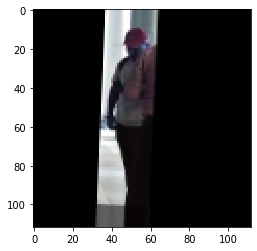

In [20]:
plt.imshow(images[0])

In [21]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [22]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound,
                             dtype=dtype)

In [23]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer=init_pytorch,
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [24]:
def resnet_v2(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    print('num_res_blocks ', num_res_blocks)
    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(4):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
        
        num_filters_in = num_filters_out

    # Add classifier on top.
    neck = x
    print(x.shape)
    # v2 has BN-ReLU before Pooling
    #     x = BatchNormalization()(x)
    #     x = Activation('relu')(x)
    #     x = AveragePooling2D(pool_size=8)(x)
    #     y = Flatten()(x)
    
    
    #     outputs = Dense(num_classes,
    #                     activation='softmax',
    #                     kernel_initializer='he_normal')(y)
    def build_tower(in_layer):
        in_layer = Convolution2D(256, 3, activation='relu',
                                 kernel_initializer=init_pytorch,
                                 use_bias=False )(in_layer)
        in_layer = BatchNormalization()(in_layer)
        in_layer = Dropout(0.2)(in_layer)
        
        in_layer = MaxPool2D()(in_layer)
        in_layer = Activation('relu')(in_layer)

        #in_layer = Dropout(0.2)(in_layer)
        
        in_layer = Convolution2D(128, 1, activation='relu',
                                 kernel_initializer=init_pytorch,
                                 use_bias=False)(in_layer)
        in_layer = BatchNormalization()(in_layer)
        in_layer = Activation('relu')(in_layer)
        in_layer = Dropout(0.2)(in_layer)
        
                
        in_layer = MaxPool2D()(in_layer)
        #in_layer = Dropout(0.2)(in_layer)
        
        return in_layer
    
    def build_head(name, in_layer):
        print(in_layer.shape)
        in_layer = BatchNormalization()(in_layer)
        in_layer = Activation('relu')(in_layer)
        in_layer = Convolution2D(num_units[name], 1,
                                 kernel_initializer=init_pytorch,
                                 use_bias=False)(in_layer)
        in_layer = GlobalAveragePooling2D()(in_layer)
        return Activation(activation='softmax', name=f"{name}_output")(in_layer)
    
    gender = build_head('gender', build_tower(neck))
    image_quality = build_head('image_quality', build_tower(neck))
    age = build_head('age', build_tower(neck))
    weight = build_head('weight', build_tower(neck))
    bag = build_head('bag', build_tower(neck))
    footwear = build_head('footwear', build_tower(neck))
    emotion = build_head('emotion', build_tower(neck))
    pose = build_head('pose', build_tower(neck))
    
    # Instantiate model.
    #model = Model(inputs=inputs, outputs=outputs)
    
    model = Model(inputs=inputs,
             outputs=[gender, image_quality, age, weight, bag, footwear, emotion, pose])
    return model

model = resnet_v2(input_shape=input_shape, depth=depth)

num_res_blocks  3










(?, 14, 14, 512)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

(?, 3, 3, 128)
(?, 3, 3, 128)
(?, 3, 3, 128)
(?, 3, 3, 128)
(?, 3, 3, 128)
(?, 3, 3, 128)
(?, 3, 3, 128)
(?, 3, 3, 128)


In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
from keras.optimizers import SGD

In [27]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [28]:
history = model.fit_generator(generator=train_gen,
                   validation_data=valid_gen,
                   use_multiprocessing=True,
                   workers=6,
                   epochs=10,
                   verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
360/360 [==============================] - 112s 312ms/step - loss: 8.1387 - gender_output_loss: 0.6750 - image_quality_output_loss: 0.9897 - age_output_loss: 1.4472 - weight_output_loss: 1.0055 - bag_output_loss: 0.9275 - footwear_output_loss: 0.9949 - emotion_output_loss: 0.9372 - pose_output_loss: 0.9395 - gender_output_acc: 0.5746 - image_quality_output_acc: 0.5416 - age_output_acc: 0.3802 - weight_output_acc: 0.6256 - bag_output_acc: 0.5569 - footwear_output_acc: 0.5122 - emotion_output_acc: 0.6960 - pose_output_acc: 0.6063 - val_loss: 8.3220 - val_gender_output_loss: 0.6680 - val_image_quality_output_loss: 1.0014 - val_age_output_loss: 1.4702 - val_weight_output_loss: 1.0716 - val_bag_output_loss: 0.9347 - val_footwear_output_loss: 0.9864 - val_emotion_output_loss: 1.0091 - val_pose_output_loss: 0.9582 - val_gender_output_acc: 0.5857 - val_image_quality_output_acc: 0.5590 - v

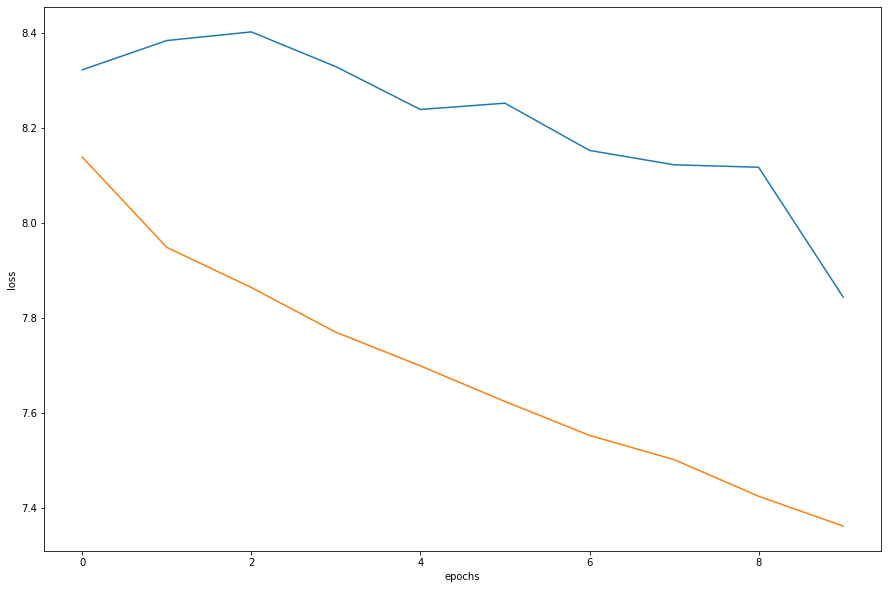

In [29]:
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history['val_loss'])
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [30]:
history = model.fit_generator(generator=train_gen,
                   validation_data=valid_gen,
                   use_multiprocessing=True,
                   workers=6,
                   epochs=20,
                   verbose=1)

Epoch 1/20
360/360 [==============================] - 102s 283ms/step - loss: 7.2731 - gender_output_loss: 0.5073 - image_quality_output_loss: 0.9498 - age_output_loss: 1.3769 - weight_output_loss: 0.9494 - bag_output_loss: 0.8555 - footwear_output_loss: 0.8489 - emotion_output_loss: 0.8772 - pose_output_loss: 0.6870 - gender_output_acc: 0.7435 - image_quality_output_acc: 0.5556 - age_output_acc: 0.3997 - weight_output_acc: 0.6391 - bag_output_acc: 0.6064 - footwear_output_acc: 0.6142 - emotion_output_acc: 0.7134 - pose_output_acc: 0.7128 - val_loss: 8.1817 - val_gender_output_loss: 0.5972 - val_image_quality_output_loss: 0.9850 - val_age_output_loss: 1.4751 - val_weight_output_loss: 1.1367 - val_bag_output_loss: 0.9439 - val_footwear_output_loss: 0.9113 - val_emotion_output_loss: 1.1039 - val_pose_output_loss: 0.8073 - val_gender_output_acc: 0.6860 - val_image_quality_output_acc: 0.5398 - val_age_output_acc: 0.3690 - val_weight_output_acc: 0.6174 - val_bag_output_acc: 0.5691 - val_foo

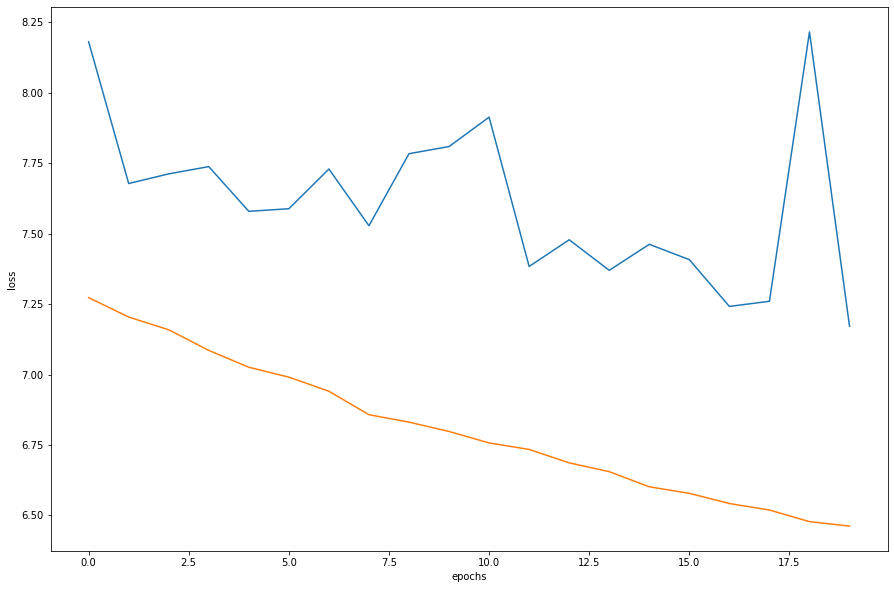

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history['val_loss'])
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [32]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [33]:
history.history

{'val_loss': [8.181698614551175,
  7.6782958892083935,
  7.712513123789141,
  7.738277096902171,
  7.579479602075392,
  7.588744548059279,
  7.729762138858918,
  7.528429477445541,
  7.784158275973413,
  7.80953953343053,
  7.913837617443454,
  7.383749485015869,
  7.478538851584157,
  7.369972059803624,
  7.46239742155998,
  7.407887658765239,
  7.241839331965292,
  7.260160184675647,
  8.21655539543398,
  7.171502667088663],
 'val_gender_output_loss': [0.597187428705154,
  0.4979322523840012,
  0.4801279392934615,
  0.49318684012659136,
  0.47445045075108927,
  0.46574959543443495,
  0.5239471620129,
  0.450475747546842,
  0.47531760604150836,
  0.4480279049565715,
  0.42829724857884066,
  0.42031985905862623,
  0.4142247082725648,
  0.4990122539381827,
  0.39649118146588724,
  0.4012533445512095,
  0.4257836130357558,
  0.3798117435747577,
  0.45261460350405786,
  0.3950509390523357],
 'val_image_quality_output_loss': [0.9850378882500433,
  0.9733200553924807,
  1.0023806383532863,


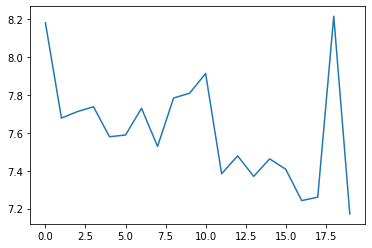

In [34]:
plt.plot(history.epoch, history.history['val_loss'])

In [35]:
import tensorflow as tf

In [36]:
tf.__version__

'1.15.0'

In [37]:
keras.__version__

'2.2.4'

In [38]:
history = model.fit_generator(generator=train_gen,
                   validation_data=valid_gen,
                   use_multiprocessing=True,
                   workers=6,
                   epochs=100,
                   verbose=1)

Epoch 1/100
360/360 [==============================] - 97s 270ms/step - loss: 6.4144 - gender_output_loss: 0.3193 - image_quality_output_loss: 0.8919 - age_output_loss: 1.2922 - weight_output_loss: 0.8839 - bag_output_loss: 0.7612 - footwear_output_loss: 0.7687 - emotion_output_loss: 0.8377 - pose_output_loss: 0.4381 - gender_output_acc: 0.8628 - image_quality_output_acc: 0.5790 - age_output_acc: 0.4332 - weight_output_acc: 0.6524 - bag_output_acc: 0.6729 - footwear_output_acc: 0.6590 - emotion_output_acc: 0.7133 - pose_output_acc: 0.8313 - val_loss: 7.1462 - val_gender_output_loss: 0.3689 - val_image_quality_output_loss: 0.9532 - val_age_output_loss: 1.3488 - val_weight_output_loss: 1.0966 - val_bag_output_loss: 0.8792 - val_footwear_output_loss: 0.8043 - val_emotion_output_loss: 0.9710 - val_pose_output_loss: 0.5028 - val_gender_output_acc: 0.8402 - val_image_quality_output_acc: 0.5610 - val_age_output_acc: 0.4194 - val_weight_output_acc: 0.5781 - val_bag_output_acc: 0.6426 - val_foo

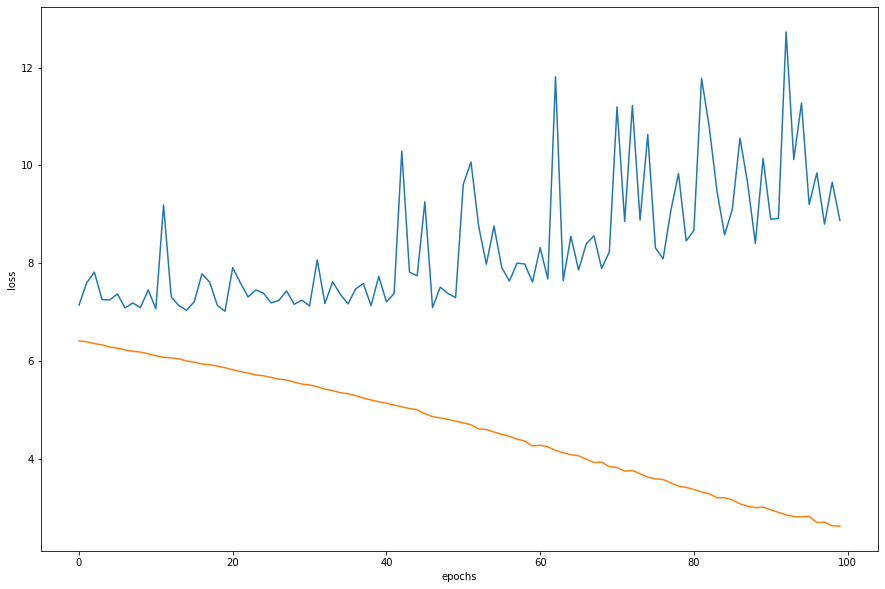

In [39]:

plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history['val_loss'])
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()